# Multi-Class Single-Label classification

The natural extension of binary classification is a multi-class classification task.
We first approach multi-class single-label classification, which makes the assumption that each example is assigned to one and only one label.

We use the Intelliznz data set, which consists of a classification into three mutually-exclusive classes; call these $A(0-50€)$, $B(50-100€)$ and $C(>100€)$.

While one could train three unary predicates $A(x)$, $B(x)$ and $C(x)$, it turns out to be more effective if this problem is modelled by a single binary predicate $P(x,l)$, where $l$ is a variable denoting a multi-class label, in this case classes $A$, $B$ or $C$.
- This syntax allows one to write statements quantifying over the classes, e.g. $\forall x ( \exists l ( P(x,l)))$.
- Since the classes are mutually-exclusive in this case, the output layer of the $\mathtt{MLP}$ representing $P(x,l)$ will be a $\mathtt{softmax}$ layer, instead of a $\mathtt{sigmoid}$ function, to learn the probability of $A$, $B$ and $C$. This avoids writing additional constraints $\lnot (A(x) \land B(x))$, $\lnot (A(x) \land C(x))$, ...

In [2]:
import ltn
import logging; logging.basicConfig(level=logging.INFO)
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data

Load the Intellizenz dataset: 1.7M samples from each of three classes of veranstaltung segments (0-50€, 50-100€, >100€).

In [24]:
features = [
            'place_kirche', 'place_hotel', 'place_cafe',
            'place_theater', 'place_club', 'place_halle',
            'place_gaststaette', 'place_festhalle', 'place_kulturzentrum',
            'place_festzelt', 'place_schloss', 'place_pub',
            'place_stadthalle', 'place_park', 'place_gasthof',
            'place_kabarett', 'place_arena', 'place_schlachthof',
            'place_wandelhalle', 'place_turnhalle', 'place_buergerhaus',
            'place_museum', 'place_rathaus', 'place_staatsbad',
            'place_zelt', 'place_jazz', 'place_forum',
            'place_gymnasium', 'place_schule', 'place_sporthalle', 

            'band_kurorchester bad wil', 'band_musikverein harmonie', 'band_kasalla',
            'band_cat ballou', 'band_roncalli  royal orch', 'band_jugendblasorchester',
            'band_kurorchester bad pyr', 'band_hoehner', 'band_paveier',
            'band_domstuermer', 'band_kluengelkoepp', 'band_alleinunterhalter',
            'band_the gregorian voices', 'band_brings', 'band_musica hungarica',
            'band_concerto', 'band_bad salzuflen orches', 'band_musikverein stadtkap',
            'band_salonorchester hunga', 'band_miljoe', 'band_raeuber',
            'band_kabarett leipziger f', 'band_marita koellner', 'band_salon-orchester hung',
            'band_blaeck foeoess', 'band_schuelerinnen und sc', 'band_romain vicente',
            'band_staatliche kurkapell', 'band_musikzug der freiwil', 'band_funky marys',

            'state_bavaria','state_rhineland-palatinate',
            'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
            'state_thuringia','state_hesse',	
            'state_brandenburg', 'state_schleswig-holstein',	
            'state_berlin',	'state_mecklenburg-western pomerania',	
            'state_lower saxony', 'state_hamburg',	
            'state_saarland', 'state_saxony-anhalt',	
            'state_saxony',	'state_bremen',

            'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season', 

            'veranst_segment','vg_inkasso'
        ]

In [7]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'vg_state', 'BAND', 'PROMOTER'
features_v3 = [
'place_kirche', 'place_hotel', 'place_cafe',
 'place_theater', 'place_club', 'place_halle',
 'place_gaststaette', 'place_festhalle', 'place_kulturzentrum',
 'place_festzelt', 'place_schloss', 'place_pub',
 'place_stadthalle', 'place_park', 'place_gasthof',
 'place_kabarett', 'place_arena', 'place_schlachthof',
 'place_wandelhalle', 'place_turnhalle', 'place_buergerhaus',
 'place_museum', 'place_rathaus', 'place_staatsbad',
 'place_zelt', 'place_jazz', 'place_forum',
 'place_gymnasium', 'place_schule', 'place_sporthalle',

'band_kurorchester bad wil', 'band_musikverein harmonie', 'band_kasalla',
 'band_cat ballou', 'band_roncalli  royal orch', 'band_jugendblasorchester',
 'band_kurorchester bad pyr', 'band_hoehner', 'band_paveier',
 'band_domstuermer', 'band_kluengelkoepp', 'band_alleinunterhalter',
 'band_the gregorian voices', 'band_brings', 'band_musica hungarica',
 'band_concerto', 'band_bad salzuflen orches', 'band_musikverein stadtkap',
 'band_salonorchester hunga', 'band_miljoe', 'band_raeuber',
 'band_kabarett leipziger f', 'band_marita koellner', 'band_salon-orchester hung',
 'band_blaeck foeoess', 'band_schuelerinnen und sc', 'band_romain vicente',
 'band_staatliche kurkapell', 'band_musikzug der freiwil', 'band_funky marys',


'state_bavaria','state_rhineland-palatinate',
'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
'state_thuringia','state_hesse',	
'state_brandenburg', 'state_schleswig-holstein',	
'state_berlin',	'state_mecklenburg-western pomerania',	
'state_lower saxony', 'state_hamburg',	
'state_saarland', 'state_saxony-anhalt',	
'state_saxony',	'state_bremen'
,

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season',

# 'promoter_chorverband nrw e.v. e.v 44135', 
# 'promoter_live nation gmbh gmbh 60320', 
# 'promoter_schwaebischer chorverband e.v. e.v 70372',
# 'promoter_trinity music gmbh 10823',
# 'promoter_karsten jahnke konzertdirektion gmbh 20359',
# 'promoter_fkp scorpio konzertproduktionen gmbh gmbh 22767',
# 'promoter_prime entertainment gmbh 50672',
# 'promoter_live nation gmbh 60320',
# 'promoter_fraenkischer saengerbund e.v. e.v 96450',
# 'promoter_semmel concerts entertainment gmbh 95445',
# 'promoter_fkp scorpio konzertproduktionen gmbh 22767',
# 'promoter_hessischer saengerbund e.v. e.v 61440',
# 'promoter_trinity music gmbh gmbh 10823',
# 'promoter_europa-park gmbh & co mack kg 77977',
# 'promoter_badischer chorverband 1862 e.v. e.v 76133',
# 'promoter_prime entertainment gmbh gmbh 50672',
# 'promoter_irish pubs gaststaetten gmbh 14959',
# 'promoter_gastro event gmbh 26802',
# 'promoter_semmel concerts entertainment gmbh gmbh 95445',
# 'promoter_backstage concerts gmbh 80639',
# 'promoter_paul daly und paul fleming gbr 80331',
# 'promoter_frankfurter kulturzentrum e.v 60388',
# 'promoter_gisbert hiller 48317',
# 'promoter_kulturzentrum schlachthof wiesbaden e.v. e.v 65189',
# 'promoter_karsten jahnke konzertdirektion gmbh gmbh 20359',
# 'promoter_bayerisches wirtshaus berlin gmbh gmbh 10178',
# 'promoter_berninger musik & gastronomie gmbh 63739',
# 'promoter_graeflicher park gmbh & co. kg gmbh & co. kg 33014',
# 'promoter_thorsten wolf 04109',
# 'promoter_circus roncalli gmbh 51063'

'promoter_live nation gmbh',
'promoter_fkp scorpio konzertproduktionen gmbh', 
'promoter_trinity music gmbh', 
'promoter_karsten jahnke konzertdirektion gmbh', 
'promoter_prime entertainment gmbh', 
'promoter_semmel concerts entertainment gmbh', 
'promoter_chorverband nrw e.v', 
'promoter_schwaebischer chorverband e.v', 
'promoter_backstage concerts gmbh', 
'promoter_kulturzentrum schlachthof wiesbaden e.v', 
'promoter_irish pubs gaststaetten gmbh', 
'promoter_fraenkischer saengerbund e.v', 
'promoter_frankfurter kulturzentrum e.v', 
'promoter_circus roncalli gmbh', 
'promoter_paul daly und paul fleming gbr', 
'promoter_foerderkreis jazz und malerei muenchen e.v', 
'promoter_hessischer saengerbund e.v', 
'promoter_gastro event gmbh', 
'promoter_berninger musik & gastronomie gmbh', 
'promoter_feierwerk e.v',
'promoter_bayerisches staatsbad bad steben gmbh', 
'promoter_europa-park gmbh & co mack kg', 
'promoter_badischer chorverband 1862 e.v', 
'promoter_bayerisches wirtshaus berlin gmbh', 
'promoter_tollwood gmbh', 
'promoter_graeflicher park gmbh & co. kg',
'promoter_konzertbuero schoneberg gmbh',  	
'promoter_staatsbad salzuflen gmbh', 
'promoter_kurverwaltung bad mergentheim gmbh', 
'promoter_gisbert hiller'
]

In [8]:
df = pd.read_parquet("C:/Users/sgopalakrish/Downloads/intellizenz-model-training/data/export_features_2016_2020_v3.parquet.gzip")


X = df[features_v3]
y = df['veranst_segment'].astype('int')

# Encode categorical labels
l_enc = LabelEncoder()
y = l_enc.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=4)

In [36]:
pd.set_option('display.max_columns', None)

In [37]:
# X_train['vg_datum_month']
# 'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season',
X_train

,place_kirche,place_hotel,place_cafe,place_theater,place_club,place_halle,place_gaststaette,place_festhalle,place_kulturzentrum,place_festzelt,place_schloss,place_pub,place_stadthalle,place_park,place_gasthof,place_kabarett,place_arena,place_schlachthof,place_wandelhalle,place_turnhalle,place_buergerhaus,place_museum,place_rathaus,place_staatsbad,place_zelt,place_jazz,place_forum,place_gymnasium,place_schule,place_sporthalle,band_kurorchester bad wil,band_musikverein harmonie,band_kasalla,band_cat ballou,band_roncalli royal orch,band_jugendblasorchester,band_kurorchester bad pyr,band_hoehner,band_paveier,band_domstuermer,band_kluengelkoepp,band_alleinunterhalter,band_the gregorian voices,band_brings,band_musica hungarica,band_concerto,band_bad salzuflen orches,band_musikverein stadtkap,band_salonorchester hunga,band_miljoe,band_raeuber,band_kabarett leipziger f,band_marita koellner,band_salon-orchester hung,band_blaeck foeoess,band_schuelerinnen und sc,band_romain vicente,band_staatliche kurkapell,band_musikzug der freiwil,band_funky marys,state_bavaria,state_rhineland-palatinate,state_baden-wuerttemberg,state_north rhine-westphalia,state_thuringia,state_hesse,state_brandenburg,state_schleswig-holstein,state_berlin,state_mecklenburg-western pomerania,state_lower saxony,state_hamburg,state_saarland,state_saxony-anhalt,state_saxony,state_bremen,vg_datum_year,vg_datum_month,vg_datum_day_of_week,vg_datum_season,promoter_live nation gmbh,promoter_fkp scorpio konzertproduktionen gmbh,promoter_trinity music gmbh,promoter_karsten jahnke konzertdirektion gmbh,promoter_prime entertainment gmbh,promoter_semmel concerts entertainment gmbh,promoter_chorverband nrw e.v,promoter_schwaebischer chorverband e.v,promoter_backstage concerts gmbh,promoter_kulturzentrum schlachthof wiesbaden e.v,promoter_irish pubs gaststaetten gmbh,promoter_fraenkischer saengerbund e.v,promoter_frankfurter kulturzentrum e.v,promoter_circus roncalli gmbh,promoter_paul daly und paul fleming gbr,promoter_foerderkreis jazz und malerei muenchen e.v,promoter_hessischer saengerbund e.v,promoter_gastro event gmbh,promoter_berninger musik & gastronomie gmbh,promoter_feierwerk e.v,promoter_bayerisches staatsbad bad steben gmbh,promoter_europa-park gmbh & co mack kg,promoter_badischer chorverband 1862 e.v,promoter_bayerisches wirtshaus berlin gmbh,promoter_tollwood gmbh,promoter_graeflicher park gmbh & co. kg,promoter_konzertbuero schoneberg gmbh,promoter_staatsbad salzuflen gmbh,promoter_kurverwaltung bad mergentheim gmbh,promoter_gisbert hiller
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10081544,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10773300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13419648,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10872411,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,9,5,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13037775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5,6,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [9]:
batch_size = 1024
print(y_train)
print(y_test)
ds_train = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(batch_size)

[0 2 2 ... 0 2 0]
[2 0 2 ... 0 2 0]


# LTN

Predicate with softmax `P(x,class)`

In [6]:
class MLP(tf.keras.Model):
    """Model that returns logits."""
    def __init__(self, n_classes, hidden_layer_sizes=(16,16,8)):
        super(MLP, self).__init__()
        self.denses = [tf.keras.layers.Dense(s, activation="relu") for s in hidden_layer_sizes]
        self.dense_class = tf.keras.layers.Dense(n_classes)
        self.dropout = tf.keras.layers.Dropout(0.2)
        
    def call(self, inputs, training=False):
        x = inputs
        for dense in self.denses:
            x = dense(x)
            x = self.dropout(x, training=training)
        return self.dense_class(x)

logits_model = MLP(110)#number of features
p = ltn.Predicate(ltn.utils.LogitsToPredicateModel(logits_model,single_label=True))

Constants to index/iterate on the classes

In [7]:
class_A = ltn.Constant(0, trainable=False)
class_B = ltn.Constant(1, trainable=False)
class_C = ltn.Constant(2, trainable=False)

Operators and axioms

In [8]:
Not = ltn.Wrapper_Connective(ltn.fuzzy_ops.Not_Std())
And = ltn.Wrapper_Connective(ltn.fuzzy_ops.And_Prod())
Or = ltn.Wrapper_Connective(ltn.fuzzy_ops.Or_ProbSum())
Implies = ltn.Wrapper_Connective(ltn.fuzzy_ops.Implies_Reichenbach())
Forall = ltn.Wrapper_Quantifier(ltn.fuzzy_ops.Aggreg_pMeanError(p=2),semantics="forall")

In [9]:
formula_aggregator = ltn.Wrapper_Formula_Aggregator(ltn.fuzzy_ops.Aggreg_pMeanError(p=2))

@tf.function
def axioms(features, labels, training=False):
    x_A = ltn.Variable("x_A",features[labels==0])
    x_B = ltn.Variable("x_B",features[labels==1])
    x_C = ltn.Variable("x_C",features[labels==2])
    axioms = [
        Forall(x_A,p([x_A,class_A],training=training)),
        Forall(x_B,p([x_B,class_B],training=training)),
        Forall(x_C,p([x_C,class_C],training=training))
    ]
    sat_level = formula_aggregator(axioms).tensor
    return sat_level

Initialize all layers and the static graph

In [10]:
for features, labels in ds_test:
    print("Initial sat level %.5f"%axioms(features,labels))
    break

Initial sat level 0.17118


# Training

Define the metrics. While training, we measure:
1. The level of satisfiability of the Knowledge Base of the training data.
1. The level of satisfiability of the Knowledge Base of the test data.
3. The training accuracy.
4. The test accuracy.

In [11]:
metrics_dict = {
    'train_sat_kb': tf.keras.metrics.Mean(name='train_sat_kb'),
    'test_sat_kb': tf.keras.metrics.Mean(name='test_sat_kb'),
    'train_accuracy': tf.keras.metrics.CategoricalAccuracy(name="train_accuracy"),
    'test_accuracy': tf.keras.metrics.CategoricalAccuracy(name="test_accuracy")
}

Define the training and test step

In [12]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

@tf.function
def train_step(features, labels):
    # sat and update
    with tf.GradientTape() as tape:
        sat = axioms(features, labels, training=True)
        loss = 1.-sat
    gradients = tape.gradient(loss, p.trainable_variables)
    optimizer.apply_gradients(zip(gradients, p.trainable_variables))
    sat = axioms(features, labels) # compute sat without dropout
    metrics_dict['train_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['train_accuracy'](tf.one_hot(labels,3),predictions)
    
@tf.function
def test_step(features, labels):
    # sat
    sat = axioms(features, labels)
    metrics_dict['test_sat_kb'](sat)
    # accuracy
    predictions = logits_model(features)
    metrics_dict['test_accuracy'](tf.one_hot(labels,3),predictions)

Train

In [13]:
import commons

EPOCHS = 500

commons.train(
    EPOCHS,
    metrics_dict,
    ds_train,
    ds_test,
    train_step,
    test_step,
    csv_path="intellizenz_results.csv",
    track_metrics=20
)

Epoch 0, train_sat_kb: 0.1836, test_sat_kb: 0.1835, train_accuracy: 0.4100, test_accuracy: 0.4103


KeyboardInterrupt: 

## Plot Satisfiability and Accuracy

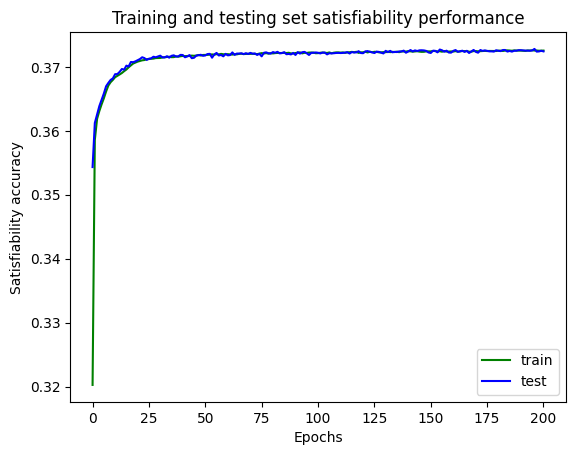

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

file = pd.read_csv('intellizenz_results.csv')

sat_train_acc = file['train_sat_kb']
sat_test_acc = file['test_sat_kb']

train_acc = file['train_accuracy']
test_acc = file['test_accuracy']

epochs = file['Epoch']

plt.plot(epochs, sat_train_acc, 'g', label='train')
plt.plot(epochs, sat_test_acc, 'b', label='test')
plt.title('Training and testing set satisfiability performance')
plt.xlabel('Epochs')
plt.ylabel('Satisfiability accuracy')
plt.legend()
plt.show()


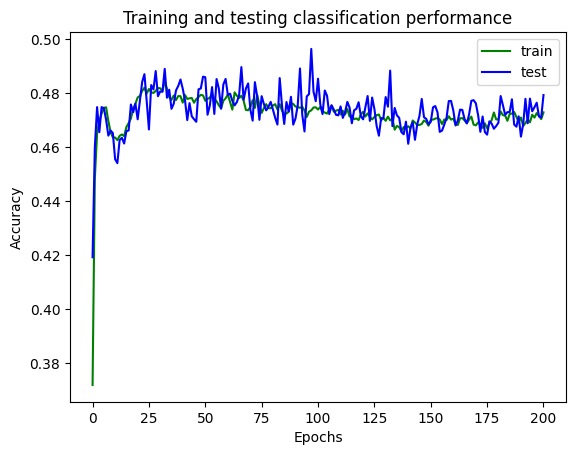

In [4]:
plt.plot(epochs, train_acc, 'g', label='train')
plt.plot(epochs, test_acc, 'b', label='test')
plt.title('Training and testing classification performance')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()